In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data
from PIL import Image
import scipy.misc
import glob
import numpy as np
import matplotlib.pyplot as plt

# Gram Matrix

In [29]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)

# Style transfer network

In [30]:
class StyleTransferNetwork(object):
    def __init__(self, content,  multi_styles):
        super(StyleTransferNetwork, self).__init__()
        self.num_of_convs_for_style = 5    # change this to account for the number of convolution layers used for style
        self.num_styles = len(multi_styles) # the number of styles we want to transfer to content
        self.mult_style_weight = [0] * self.num_styles  # weights according to average weighting of style loss
        self.styles = multi_styles
        self.log = 0 # logging the loss which will be used to plot log-loss
        self.content = content

        
        self.pastiche = Variable(content.data.clone(), requires_grad=True) # use this to initialize pastiche to content

        self.content_layers = ['conv_4_2']
        self.style_layers = []

        #self.style_layers = ['conv_1_1', 'conv_1_2', 'conv_2_1', 'conv_2_2', 'conv_3_1'] # if you want to manually
        # change the layers used for style loss uncomment this line and comment out the for loop in next line

        for i in range(0, self.num_of_convs_for_style):
             self.style_layers.append("conv_" + str(i+1) + "_1")

        
        self.style_loss_weight = [1.0 / (self.num_of_convs_for_style)] * self.num_of_convs_for_style

        
#         self.style_loss_weight = [n / (self.num_of_convs_for_style) for n in [64, 64, 128, 128, 256]]
        self.content_weight = 1     # this is alpha according to the paper
        self.style_weight = 1000    # this is beta according to paper

        self.loss_network = models.vgg19(pretrained=True)
        for param in self.loss_network.parameters():
            param.requires_grad = False
        self.gram = GramMatrix()
        self.loss = nn.MSELoss()
        self.optimizer = optim.LBFGS([self.pastiche])

        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.loss_network.cuda()
            self.gram.cuda()

    def train(self):
        def closure():
            self.optimizer.zero_grad()

            pastiche = self.pastiche

            content = self.content.clone()
            styles_to_transfer = []
            for z in range(0, self.num_styles):
                styles_to_transfer.append(self.styles[z].clone())
            styles_loss = Variable(torch.zeros(self.num_styles).type(dtype))
            content_loss = 0
            j = 0
            i = 1
            layer_count = 1
            not_inplace = lambda layer: nn.ReLU(inplace=False) if isinstance(layer, nn.ReLU) else layer
            for layer in list(self.loss_network.features):
                layer = not_inplace(layer)
                if self.use_cuda:
                    layer.cuda()

                pastiche, content = layer.forward(pastiche), layer.forward(content)

                for z in range(0, self.num_styles):
                    styles_to_transfer[z] = layer.forward(styles_to_transfer[z])

                if isinstance(layer, nn.Conv2d):
                    name = "conv_" + str(layer_count) + "_" + str(i)
                    if name in self.content_layers:
                        content_loss += self.loss(pastiche, content.detach())

                    if name in self.style_layers:
                        pastiche_g = self.gram.forward(pastiche)
                        for z in range(0, self.num_styles):
                            style_g = self.gram.forward(styles_to_transfer[z])
                            styles_loss[z] =styles_loss[z] + self.style_loss_weight[j] * self.loss(pastiche_g,
                                                                                    style_g.detach())
                        j += 1
                if isinstance(layer, nn.ReLU):
                    i += 1
                if isinstance(layer, nn.MaxPool2d):
                    layer_count += 1
                    i = 1
            tot_style_loss = sum(styles_loss)
            total_loss = self.content_weight * content_loss
            for z in range(0, self.num_styles):

                #self.mult_style_weight[z] = 1.0 / self.num_styles  # uncomment this line and comment out next
                # if custom (equal in this case) weight is needed for each style

                self.mult_style_weight[z] = styles_loss[z]/tot_style_loss # comment out if custom weights for each style
                # is needed
                total_loss += self.style_weight * self.mult_style_weight[z] * styles_loss[z]
            total_loss.backward()
            self.log = total_loss
            return total_loss

        self.optimizer.step(closure)
        return self.pastiche

# Input image preprocessing

In [31]:
imsize = 256

mean_imgnet = [123.68/255, 116.779/255, 103.939/255]
neg_mean_imgnet = [-123.68/255, -116.779/255, -103.939/255]




pre_process = transforms.Compose([transforms.Resize((imsize, imsize)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=mean_imgnet, # subtract imagenet mean and normalize
                                                std=[1,1,1]),
                                  transforms.Lambda(lambda x: x.mul_(255)),  # to have the range from [-255, 255]
                                  ])



# Output Image Post-processing

In [32]:
post_process_a = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1. / 255)),  # convert back from [-255, 255]
                                     transforms.Normalize(mean=neg_mean_imgnet, # add imagenet mean back
                                                std=[1,1,1]),
                                     ])


post_process_b = transforms.Compose([transforms.ToPILImage()])


# Helper Functions

In [33]:
def postp(tensor):
    t = post_process_a(tensor)
    t[t > 1] = 1 # to clamp results in the range [0,1]
    t[t < 0] = 0 # to clamp results in the range [0,1]
    img = post_process_b(t)
    return img


def load_styles(path):
    styles = []
    for file in glob.glob(path+"/*.jpg"):
        styles.append(image_loader(file).type(dtype))

    return styles


def image_loader(image_name):
    image = Image.open(image_name)
    image = pre_process(image)
    image = Variable(image.unsqueeze(0))
    return image

# CUDA Configurations

In [34]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# Main

In [35]:
def main():
    path_styles = "./styles"
    path_contents = "./contents"
    out_path = "./outputs"
    num_epochs = 50
    styles = load_styles(path_styles)
    for cont_file in glob.glob(path_contents + "/*.jpg"):
        log = []
        content = image_loader(cont_file).type(dtype)

        style_cnn = StyleTransferNetwork(content, styles)
        out_counter = 0
        for i in range(num_epochs + 1):
            pastiche = style_cnn.train()
            print(str(style_cnn.log.data.cpu().numpy()[0]) + " " + str(i))
            log.append([i, style_cnn.log.data.cpu().numpy()[0]])
            if i % 10 == 0:
                print "Iteration: " , i
                cont_name = cont_file.replace('./contents/', "")
                cont_name = cont_name.replace(".jpg", "")
                path = out_path + "/" + cont_name + "_%d.png" % out_counter
                out_img = postp(pastiche.data[0].cpu().squeeze())
                scipy.misc.imsave(path, out_img)
                out_counter += 1
        a = np.array(log)
        plt.figure(2)
        plt.plot(a[1:, 0], np.log(a[1:, 1]))
        plt.xlabel('Iteration')
        plt.ylabel('loss(log)')
        plt.show()


# Runing the code

15421516.0 0
Iteration:  0


/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


13712370.0 1
13361236.0 2
13239568.0 3
13185068.0 4
13154082.0 5
13130258.0 6
13114930.0 7
13101422.0 8
13091360.0 9
13082740.0 10
Iteration:  10
13075776.0 11
13070560.0 12
13065896.0 13
13062211.0 14
13058646.0 15
13056143.0 16
13053716.0 17
13051740.0 18
13049924.0 19
13048477.0 20
Iteration:  20
13047162.0 21
13045968.0 22
13044944.0 23
13044054.0 24
13043194.0 25
13042500.0 26
13041847.0 27
13041232.0 28
13040710.0 29
13040202.0 30
Iteration:  30
13039779.0 31
13039356.0 32
13038997.0 33
13038637.0 34
13038314.0 35
13038016.0 36
13037746.0 37
13037489.0 38
13037244.0 39
13037022.0 40
Iteration:  40
13036806.0 41
13036613.0 42
13036433.0 43
13036261.0 44
13036106.0 45
13035954.0 46
13035808.0 47
13035670.0 48
13035542.0 49
13035418.0 50
Iteration:  50


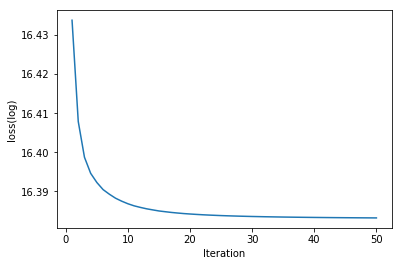

In [36]:
main()